#### Load necessary packages

In [8]:
import numpy as np
import xarray as xr
import pickle
import math
import matplotlib.pyplot as plt
import warnings
import cftime

#### Data strategy
* Read in text file that lists float files with adjusted pH data
* Define two arrays of shape (360, 180, 360), one initialized with NaNs for grid cell averages,
  ones with zeros to keep count of measurements falling in each grid cell
* Loop over float files, check whether non-NaN adjusted pH is available, and average all data above 10 dbar (~10m) for each profiles
* Loop over profiles within each float file, check if time between 1993-2022,
  identify which grid cell they fall into, and update grid cell mean accordingly

In [9]:
with open(
    '../data/202405-BgcArgoSprof/floats_with_PH_IN_SITU_TOTAL_ADJUSTED.txt', 'r'
) as file:
    files = [line.strip()[2:] for line in file]

In [10]:
def years_and_months(ds):
    years = ds.JULD_LOCATION.values.astype('datetime64[Y]').astype(int) + 1970
    months = ds.JULD_LOCATION.values.astype('datetime64[M]').astype(int) % 12
    return years, months

def lats_and_lons(ds):
    return ds.LATITUDE.values, ds.LONGITUDE.values

In [11]:
files_nonNaN = []
for file in files:
    ds = xr.open_dataset("../data/202405-BgcArgoSprof/" + file, decode_times=False)
    if np.any(np.isfinite(ds.PH_IN_SITU_TOTAL_ADJUSTED.values)):
        files_nonNaN.append(file)

In [12]:
print("Original number of files: ", len(files))
print("Number of files with data: ", len(files_nonNaN))

Original number of files:  608
Number of files with data:  454


In [13]:
mean_array = np.full((360, 180, 360), np.nan)
num_array = np.zeros((360, 180, 360))

maxima = []
minima = []

for file in files_nonNaN:
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        ds = xr.open_dataset("../data/202405-BgcArgoSprof/" + file)
        
        # Flag to check if a RuntimeWarning is caught
        runtime_warning_caught = False

        for warning in w:
            if issubclass(warning.category, RuntimeWarning):
                print("Caught RuntimeWarning for file {}. Skipping this file.".format(file))
                runtime_warning_caught = True
                break  # Exit the inner loop

        if runtime_warning_caught:
            continue  # Skip this file
                
    years, months = years_and_months(ds)
    lats, lons = lats_and_lons(ds)
    lg_10db = ds.PRES_ADJUSTED.values > 10
    ph = ds.PH_IN_SITU_TOTAL_ADJUSTED.values
    maxima.append(np.nanmax(ph))
    minima.append(np.nanmin(ph))
    ph[lg_10db] = np.nan
    ph[ph < 7.5] = np.nan # ignore  too small pH values
    ph[ph > 8.5] = np.nan # ignore  too large pH values

    with warnings.catch_warnings(): 
        # ignore mean of empty slice warning, occurs when profile has
        # no pH data in the upper 10m, this case is handled below.
        warnings.simplefilter("ignore", category=RuntimeWarning)
        ph_surf = np.nanmean(ph, axis=1)
    
    for profile in range(len(ph_surf)):
        if 1993 <= years[profile] <= 2022:
            if np.all(np.isfinite([ph_surf[profile], lats[profile], lons[profile]])):
                time_index = 12 * (years[profile] - 1993) + months[profile]
                lat_index = math.floor(lats[profile]) + 90
                lon_index = math.floor(lons[profile]) + 180
                num_array[time_index, lat_index, lon_index] += 1
                num_obs = num_array[time_index, lat_index, lon_index]
                if num_obs == 1:
                    mean_array[time_index, lat_index, lon_index] = ph_surf[profile]
                elif num_obs > 1:
                    mean_array[time_index, lat_index, lon_index] = (
                        (num_obs-1) / num_obs *  mean_array[
                        time_index, lat_index, lon_index]
                        + 1 / num_obs * ph_surf[profile])

Caught RuntimeWarning for file dac/aoml/5905992_Sprof.nc. Skipping this file.


/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Caught RuntimeWarning for file dac/aoml/5906224_Sprof.nc. Skipping this file.


/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Caught RuntimeWarning for file dac/aoml/5906218_Sprof.nc. Skipping this file.


/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Caught RuntimeWarning for file dac/aoml/5906205_Sprof.nc. Skipping this file.


/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/friedrich/.miniconda3/envs/torchen

Caught RuntimeWarning for file dac/aoml/5906441_Sprof.nc. Skipping this file.
Caught RuntimeWarning for file dac/aoml/5906296_Sprof.nc. Skipping this file.
Caught RuntimeWarning for file dac/aoml/5906222_Sprof.nc. Skipping this file.


/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Caught RuntimeWarning for file dac/aoml/5906247_Sprof.nc. Skipping this file.


/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Caught RuntimeWarning for file dac/aoml/5906315_Sprof.nc. Skipping this file.
Caught RuntimeWarning for file dac/aoml/5905132_Sprof.nc. Skipping this file.


/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Caught RuntimeWarning for file dac/aoml/5906293_Sprof.nc. Skipping this file.


/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Caught RuntimeWarning for file dac/aoml/5906223_Sprof.nc. Skipping this file.
Caught RuntimeWarning for file dac/aoml/5906226_Sprof.nc. Skipping this file.


/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Caught RuntimeWarning for file dac/aoml/5906493_Sprof.nc. Skipping this file.
Caught RuntimeWarning for file dac/aoml/5906227_Sprof.nc. Skipping this file.
Caught RuntimeWarning for file dac/aoml/5906250_Sprof.nc. Skipping this file.


/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/friedrich/.miniconda3/envs/torchenv_mocsy_clone/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Number of profiles providing surface pH measurements: 16205
Number of grid cells with surface pH measurements: 10091


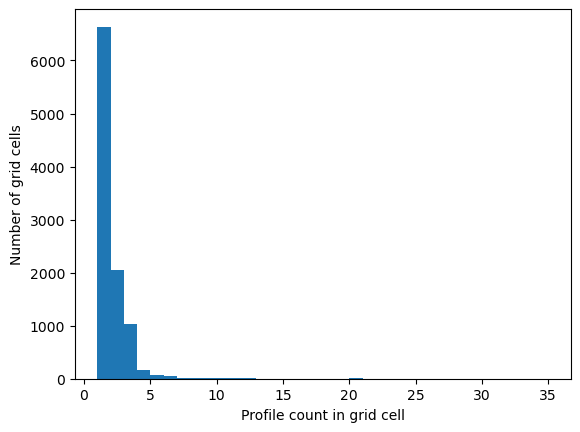

In [14]:
plt.hist(num_array[num_array > 0], bins=range(1, 36))
plt.xlabel("Profile count in grid cell")
plt.ylabel("Number of grid cells")
print("Number of profiles providing surface pH measurements: {}".format(int(np.sum(num_array))))
print("Number of grid cells with surface pH measurements: {}".format(
    int(np.sum(np.isfinite(mean_array)))))

Text(0, 0.5, 'Number of grid cells')

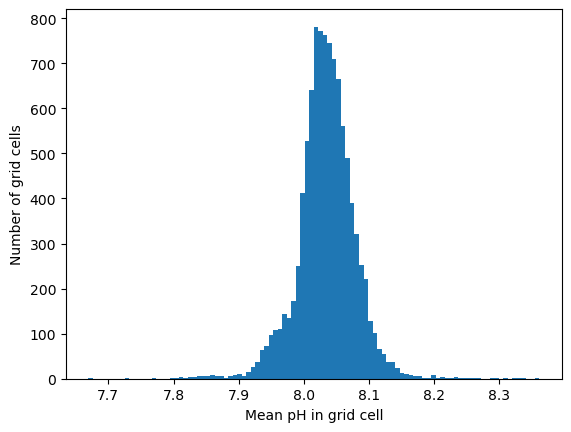

In [15]:
plt.hist(mean_array[np.isfinite(mean_array)], bins=100)
plt.xlabel("Mean pH in grid cell")
plt.ylabel("Number of grid cells")

In [16]:
print("adjusted pH values wildly vary - ignored all outside range 7.5 <= pH <= 8.5")
print("Minimum pH across all floats: ", np.nanmin(minima))
print("Maximum pH across all floats: ", np.nanmax(maxima))

adjusted pH values wildly vary - ignored all outside range 7.5 <= pH <= 8.5
Minimum pH across all floats:  -714.0168
Maximum pH across all floats:  1352.2401


In [17]:
#create coordinates for xarray dataset for export
latitudes = np.arange(-89.5, 90)
longitudes = np.arange(-179.5, 180)

start_date = cftime.DatetimeGregorian(1993, 1, 15)
end_date = cftime.DatetimeGregorian(2023, 1, 15)
times = xr.cftime_range(start=start_date, end=end_date, freq="M")

In [18]:
ds_out = xr.Dataset()
ds_out["PH_IN_SITU_TOTAL_ADJUSTED_gridded"] = xr.DataArray(
    mean_array, coords ={"time": times, "latitude": latitudes, "longitude": longitudes}
).astype('float32')
ds_out["PH_IN_SITU_TOTAL_ADJUSTED_number_of_contributing_profiles"] = xr.DataArray(
    num_array, coords ={"time": times, "latitude": latitudes, "longitude": longitudes}
).astype('float32')

In [19]:
ds_out

<xarray.Dataset>
Dimensions:                                                    (time: 360,
                                                                latitude: 180,
                                                                longitude: 360)
Coordinates:
  * time                                                       (time) object ...
  * latitude                                                   (latitude) float64 ...
  * longitude                                                  (longitude) float64 ...
Data variables:
    PH_IN_SITU_TOTAL_ADJUSTED_gridded                          (time, latitude, longitude) float32 ...
    PH_IN_SITU_TOTAL_ADJUSTED_number_of_contributing_profiles  (time, latitude, longitude) float32 ...

In [20]:
ds_out.to_netcdf("../data/202405-BgcArgoSprof_pH_gridded.nc")